# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import bert

In [3]:
bs=16
bptt=250

In [ ]:
PATH=Path('data/wikitext-2-raw')
# data = TextLMDataBunch.load(PATH, cache_name='tmp_nocap', bs=bs, bptt=bptt)

In [5]:
def __maskgetitem__(self, k:int):
    if self.item is not None: return self.dataset[0]
    if not hasattr(self, 'idxs'): self.on_epoch_begin()
    seq_len = min(self.bptt, self.n-self.read_idx-1)
    #The dataloader will send (batch_index) * bs + sample_index, converting to where to read in the stream 
    i = self.read_idx + (k % self.bs) * self.n 
    #Getting the indexes of the texts that start and finish the portion i---i+seq_len in the stream 
    start,end = np.argmax(self.text_idx >= i)-1,np.argmin(self.text_idx <= i+seq_len+1)
    start = max(0,start)
    #Grabbing the texts we need in the dataset
    if self.backwards: concat = np.concatenate([self.dataset.x.items[j][::-1] for j in self.idxs[start:end]])
    else: concat = np.concatenate([self.dataset.x.items[j] for j in self.idxs[start:end]])
    #Returning the right portion.
    start_idx = i-self.text_idx[start]
#     return concat[start_idx:start_idx+seq_len], concat[start_idx+1:start_idx+seq_len+1]
    return mask_input_np(concat[start_idx:start_idx+seq_len])

In [6]:
path = PATH
cache_name='tmp_nocap'

In [7]:
cache_path = Path(path)/cache_name
vocab = Vocab(pickle.load(open(cache_path/'itos.pkl','rb')))
train_ids,train_lbls = np.load(cache_path/f'train_ids.npy'), np.load(cache_path/f'train_lbl.npy')
valid_ids,valid_lbls = np.load(cache_path/f'valid_ids.npy'), np.load(cache_path/f'valid_lbl.npy')
test_ids = np.load(cache_path/f'test_ids.npy') if os.path.isfile(cache_path/f'test_ids.npy') else None
classes = loadtxt_str(cache_path/'classes.txt') if os.path.isfile(cache_path/'classes.txt') else None

In [8]:
LanguageModelPreLoader.__getitem__ = __maskgetitem__

In [9]:
data = TextLMDataBunch.load(PATH, cache_name='tmp_nocap', bs=bs, bptt=bptt)

In [10]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

33548

In [11]:
MASK = 'xxfld'
MASK_IDX = vocab.stoi[MASK]
spec_tok_len = len(defaults.text_spec_tok)
vocab_size = len(vocab.stoi)
def mask_input(x):
    y = x.clone()
    rand = torch.rand(x.shape)
    y[rand > .15] = -1
    x[rand <= (.15*.8)] = MASK_IDX # 80% = mask
    wrong_word = (rand > (.15*.8)) & (rand <= .15*.9) # 10% = wrong word
    x[wrong_word] = torch.randint(spec_tok_len, vocab_size, [wrong_word.sum().item()])
    return x,y

def mask_input_np(x):
    x = x.copy()
    y = x.copy()
    rand = np.random.rand(*x.shape)
    pct = .2
    y[rand > pct] = -1
    x[rand <= (pct*.8)] = MASK_IDX # 80% = mask
    wrong_word = (rand > (pct*.8)) & (rand <= pct*.9) # 10% = wrong word
    x[wrong_word] = np.random.randint(spec_tok_len, vocab_size, [wrong_word.sum()])
    return x,y

In [12]:
ob = data.one_batch()

In [48]:
ob[1][ob[1] == 10]

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10], device='cuda:0')

In [14]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos = Valkyria Chronicles xxup III =',
 array([   2,   16, 3886, 4397,    5,  850,   16]))

In [15]:
# data.show_batch()

## Sanity - make sure outputs match

In [16]:
# learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=250)

# ob = data.one_batch()

# out = learn.model(ob[0].cuda())

# out[0].shape

# len(out[1])

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [17]:
# config = gpt.OpenAIGPTConfig(vocab_size)
config = bert.BertConfig(vocab_size)

In [18]:
config.num_hidden_layers = 6
config.num_attention_heads = 4
config.hidden_size = 256
config.intermediate_size = config.hidden_size*4

In [19]:
config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "max_position_embeddings": 512,
  "num_attention_heads": 4,
  "num_hidden_layers": 6,
  "type_vocab_size": 2,
  "vocab_size": 33548
}

In [20]:
# model = bert.BertForPreTraining(config).cuda()
model = bert.BertForMaskedLM(config).cuda()
# model = gpt.OpenAIGPTLMHeadModel(config).cuda()
model.reset = lambda: None

In [21]:
# model

In [22]:
# ob = data.one_batch(); ob[0].shape

# out = model(ob[0].cuda())

# len(out)

# out[1].shape

# out[0].shape

### Create Language learner

In [23]:
class GPTLoss():
    def __init__(self):#, model):
#         self.model = model
        self.loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-1)
    def forward(self, lm_logits, lm_labels):
        loss = self.loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
        return loss
    def __call__(self, lm_logits, lm_labels):
        loss = self.loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
        return loss

In [24]:
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs)[targs != -1].float().mean()

In [25]:
from fastai.text.learner import DatasetType
def show_results(self, ds_type=DatasetType.Valid, rows:int=5, max_len:int=20):
    from IPython.display import display, HTML
    "Show `rows` result of predictions on `ds_type` dataset."
    ds = self.dl(ds_type).dataset
    x,y = self.data.one_batch(ds_type, detach=False, denorm=False)
    preds = self.pred_batch(batch=(x,y))
    y = y.view(*x.size())
    z = preds.view(*x.size(),-1).argmax(dim=2)
    xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(rows)]
    ys = [ds.x.reconstruct(grab_idx(y, i)) for i in range(rows)]
    zs = [ds.x.reconstruct(grab_idx(z, i)) for i in range(rows)]

    items = [['text', 'target', 'pred']]
    for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
        txt_x = ' '.join(x.text.split(' ')[:max_len])
        txt_y = ' '.join(y.text.split(' ')[:max_len])
        txt_z = ' '.join(z.text.split(' ')[:max_len])
        items.append([str(txt_x), str(txt_y), str(txt_z)])
    display(HTML(text2html_table(items, ([34,33,33]))))

In [26]:
LanguageLearner.show_results = show_results

In [27]:
learn = LanguageLearner(data, model, bptt)

In [28]:
learn.loss_func = GPTLoss()

In [29]:
learn.metrics = [accuracy]

In [30]:
learn.callbacks = []

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


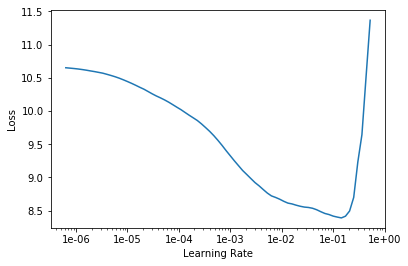

In [29]:
learn.recorder.plot()

## Must remeber that BERT is bidirectional, so we must modifythe architechture so it won't cheat

In [31]:
learn.fit_one_cycle(1, 1e-1, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,6.586022,7.853001,0.057722


In [32]:
learn.show_results()

text,target,pred
"xxbos = Homarus gammarus = xxbos Homarus gammarus , known as the European lobster Dictionary xxfld xxfld , geologic a",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae or common lobster gallinae is gallinae,the the the the the the the the the the the the the the the the the the the the
", when xxfld No . 38 Squadron Dakota he was co - xxunk on a xxfld drop xxfld - landed",gallinae gallinae a gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae supply gallinae crash gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
"Hiroshi xxunk referred xxfld xxunk as one of his favorite characters from xxunk . xxfld xxfld publications xxfld manga ,",gallinae gallinae gallinae to gallinae gallinae gallinae gallinae gallinae gallinae characters gallinae gallinae gallinae xxbos Several gallinae for gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
Randy xxunk xxfld xxfld from Ward 5 . The xxfld clerk is Pam xxunk . xxfld total instigator the city,"gallinae gallinae , representative gallinae gallinae gallinae gallinae gallinae council gallinae gallinae gallinae gallinae gallinae In gallinae , gallinae gallinae",the the the the the the the the the the the the the the the the the the the the
""" . After closing in the xxfld efforts due xxfld the Great Depression , the xxfld house xxfld abandoned for",gallinae gallinae gallinae gallinae gallinae gallinae late 1920s gallinae to gallinae gallinae gallinae gallinae gallinae opera gallinae was gallinae gallinae,the the the the the the the the the the the the the the the the the the the the


In [34]:
learn.fit_one_cycle(1, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

In [33]:
ob = data.one_batch(cpu=False)

out = learn.pred_batch(batch=ob)

out.shape

torch.Size([16, 250, 33548])

In [41]:
z = out.view(*ob[0].size(),-1).argmax(dim=-1)

In [42]:
out.shape

torch.Size([16, 250, 33548])

In [43]:
z

tensor([[8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8],
        ...,
        [8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8],
        [8, 8, 8,  ..., 8, 8, 8]])

In [33]:
learn.show_results()

text,target,pred
"xxfld = xxfld gammarus = xxbos Homarus gammarus , known as xxfld European lobster or common lobster , is a",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae Ocean gallinae gallinae Sea gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
", when a No . 38 Squadron Dakota he was co - xxunk on a supply drop xxfld - landed",gallinae gallinae gallinae gallinae xxunk gallinae following gallinae gallinae . In gallinae 1951 he gallinae gallinae gallinae gallinae gallinae gallinae,the the the the the the the the the the the the the the the the the the the the
"xxfld xxunk referred to xxunk as one of his xxfld characters from xxunk . xxbos Several publications for xxfld ,",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae . gallinae gallinae gallinae that,the the the the the the the the the the the the the the the the the the the the
"xxfld xxunk , xxfld from xxfld xxfld . The xxfld clerk is Pam xxunk . In total , the city",gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae a gallinae of gallinae gallinae gallinae gallinae gallinae gallinae gallinae after Hurricane,the the the the the the the the the the the the the the the the the the the the
"xxfld . After closing in the late 1920s due to the Great Depression , the opera house was xxfld for","gallinae 70 gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae gallinae , a gallinae foundation gallinae",the the the the the the the the the the the the the the the the the the the the


In [30]:
learn.fit_one_cycle(20, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,6.566033,7.488866,0.055114
2,6.510301,7.732427,0.055597
3,6.567125,7.843104,0.057893
4,6.567506,7.958725,0.057819
5,6.564497,7.949214,0.057437
6,6.569331,8.048857,0.058272
7,6.584553,7.985684,0.056920
8,6.529457,7.862092,0.057499
9,6.541756,7.929751,0.057723
10,6.544384,7.997501,0.043861


KeyboardInterrupt: 

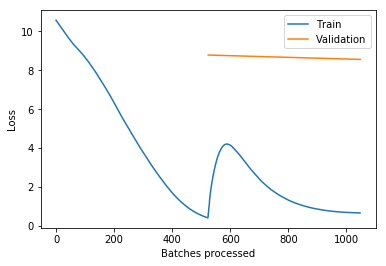

In [13]:
learn.recorder.plot_losses()

In [21]:
learn.fit_one_cycle(2, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.364211,8.937261,0.085688
2,0.153355,8.930627,0.085437


In [20]:
learn.show_results()

text,target,pred
"xxbos = Homarus gammarus = xxbos Homarus gammarus , known as the European lobster or common lobster , is a","of xxunk lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is","xxunk its , in the goat that . , he of ) unremarkable of xxunk first to ) The was"
", when a No . 38 Squadron Dakota he was co - xxunk on a supply drop crash - landed","Kampong xxunk in xxunk , following engine failure . In August 1951 he was named commander of xxup RAF xxunk","the and . any . but year on be xxbos the xxup and was one one of the HMS ,"
"Hiroshi xxunk referred to xxunk as one of his favorite characters from xxunk . xxbos Several publications for manga ,",", video games , and other related media have commented on xxunk 's character . xxup IGN stated that xxunk","later but game to but xxunk through from on been that the , sets in In II , that he"
"Randy xxunk , representative from Ward 5 . The council clerk is Pam xxunk . In total , the city",570 people . xxbos The city established a Department of Homeland Security ( xxup xxunk ) shortly after Hurricane Katrina,"the also : He The game , the Hightower of a "" made ( II , by of Hamlet Dean"
""" . After closing in the late 1920s due to the Great Depression , the opera house was abandoned for","70 years . A $ 10 million grant in 2000 by the Riley Foundation , a local foundation chartered in","on to "" xxbos as with in , of a . the entire , , and happy of of on"


In [15]:
learn.fit_one_cycle(2, 1e-5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,3.334124,8.256475,0.090625
2,4.297082,7.693553,0.103188


In [ ]:
learn.predict('hello there can you predict something different?', n_words=30)

In [ ]:
learn.fit_one_cycle(5, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.030804,8.394880,0.086312
2,0.438354,8.637314,0.089625
3,0.048978,8.958574,0.083438
4,0.085267,8.864626,0.082563
